<a href="https://colab.research.google.com/github/BillWorstell/derenzo_phantom_object/blob/main/CheckGeneratePhantom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

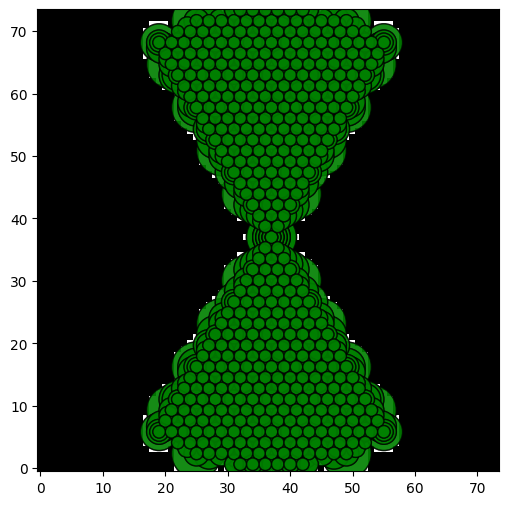

ic| phantom_mask.shape: (74, 74)


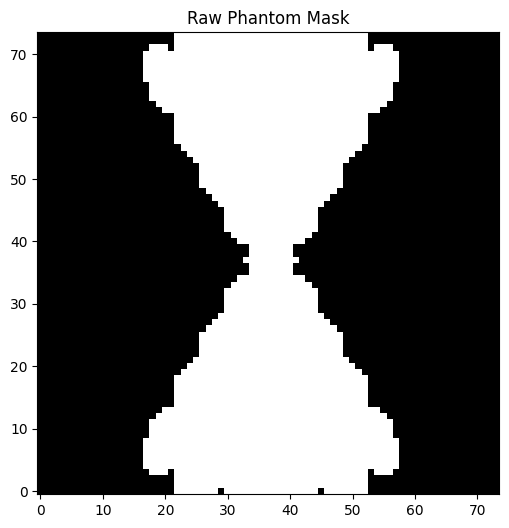

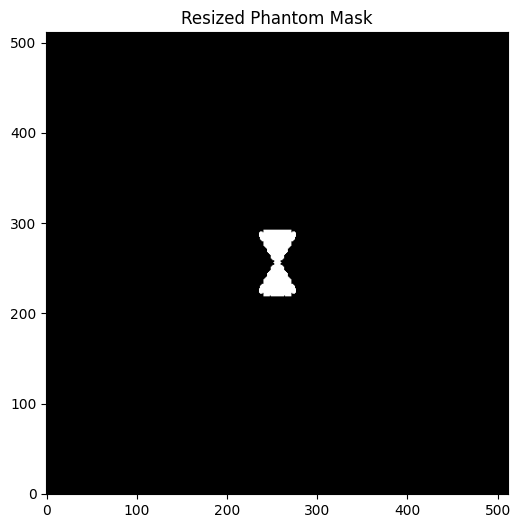

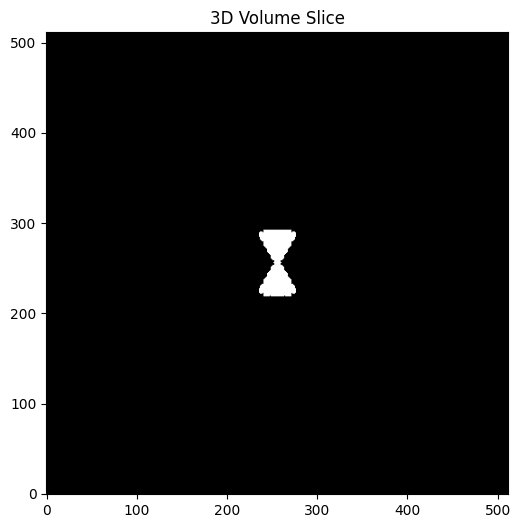

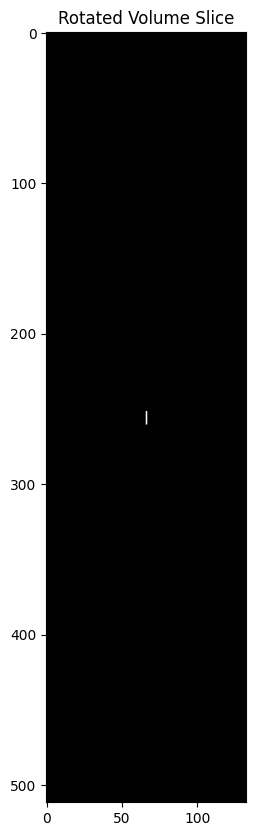

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.ndimage import rotate
from icecream import ic

class DerenzoPhantom:
    def __init__(self, radius, well_seps):
        self.radius = radius
        self.well_seps = well_seps
        self.phantom = self.create_phantom()

    def create_phantom(self):
        size = int(2 * self.radius)
        phantom = np.zeros((size, size))
        centers = self.calculate_centers()

        for sep, positions in zip(self.well_seps, centers):
            for pos in positions:
                self.add_circle(phantom, pos, sep / 2)

        return phantom

    def calculate_centers(self):
        centers = []
        for sep in self.well_seps:
            centers.append(self._generate_segment(sep))
        return centers

    def _generate_segment(self, sep):
        positions = []
        rows = int(self.radius // sep) * 2
        for i in range(rows):
            for j in range(i + 1):
                x = j * sep - i * sep / 2
                y = i * sep * np.sqrt(3) / 2
                if np.sqrt(x**2 + y**2) <= self.radius:
                    positions.append((self.radius + x, self.radius + y))
                    positions.append((self.radius - x, self.radius + y))
                    positions.append((self.radius + x, self.radius - y))
                    positions.append((self.radius - x, self.radius - y))
        return positions

    def add_circle(self, img, center, r):
        y, x = np.ogrid[:img.shape[0], :img.shape[1]]
        mask = (x - center[0])**2 + (y - center[1])**2 <= r**2
        img[mask] = 1

    def show(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(self.phantom, cmap='gray', origin='lower')
        ax.set_aspect('equal')
        for sep, positions in zip(self.well_seps, self.calculate_centers()):
            for pos in positions:
                circle = Circle(pos, sep / 2, edgecolor='black', facecolor='green', alpha=0.7)
                ax.add_patch(circle)
        plt.show()

    def get_mask(self):
        return self.phantom

def generate_phantom(volume_size=(512, 512, 133), radius=37.0, well_seps=(8.0, 6.0, 5.0, 4.0, 3.0, 2.0)):
    """
    Generate a 3D volume with a Derenzo phantom inside, with specified translations and rotations.

    Parameters:
    - volume_size: tuple of int, size of the 3D volume (default is 512x512x133).
    - radius: float, radius of the Derenzo phantom.
    - well_seps: tuple of float, separations of the wells in the phantom.

    Returns:
    - volume: 3D numpy array representing the volume with the phantom.
    """
    # Set the parameters for the phantom
    test_phantom = DerenzoPhantom(radius, well_seps)
    test_phantom.show()  # Display the created phantom
    phantom_mask = test_phantom.get_mask()
    ic(phantom_mask.shape)

    # Debug: Display the raw phantom mask
    plt.figure(figsize=(6, 6))
    plt.imshow(phantom_mask, cmap='gray', origin='lower')
    plt.title("Raw Phantom Mask")
    plt.show()

    # Resize the phantom mask to match the volume's x, y dimensions
    mask_size = phantom_mask.shape[0]
    volume_x, volume_y = volume_size[0], volume_size[1]

    phantom_mask_resized = np.zeros((volume_x, volume_y))
    offset_x = (volume_x - mask_size) // 2
    offset_y = (volume_y - mask_size) // 2
    phantom_mask_resized[offset_x:offset_x + mask_size, offset_y:offset_y + mask_size] = phantom_mask

    # Debug: Display the resized phantom mask
    plt.figure(figsize=(6, 6))
    plt.imshow(phantom_mask_resized, cmap='gray', origin='lower')
    plt.title("Resized Phantom Mask")
    plt.show()

    # Prepare 3D volume
    volume = np.zeros(volume_size)

    # Insert the 2D phantom mask into the center of the 3D volume
    z_center = volume_size[2] // 2
    volume[:, :, z_center] = phantom_mask_resized

    # Debug: Display the 3D volume slice
    plt.figure(figsize=(6, 6))
    plt.imshow(volume[:, :, z_center], cmap='gray', origin='lower')
    plt.title("3D Volume Slice")
    plt.show()

    return volume

def visualize_volume(volume, angle=0):
    """
    Visualize a slice of the 3D volume.

    Parameters:
    - volume: 3D numpy array, the volume to visualize.
    - angle: int, angle of rotation for visualization.
    """
    plt.figure(figsize=(10, 10))
    rotated_volume = rotate(volume, angle, axes=(1, 2), reshape=False)
    plt.imshow(rotated_volume[volume.shape[0] // 2], cmap='gray')
    plt.title("Rotated Volume Slice")
    plt.show()

# Set the parameters for the phantom
radius = 37.0
well_seps = (8.0, 6.0, 5.0, 4.0, 3.0, 2.0)

# Generate the Derenzo phantom volume
phantom_volume = generate_phantom(volume_size=(512, 512, 133), radius=radius, well_seps=well_seps)

# Visualize the original phantom volume
visualize_volume(phantom_volume)


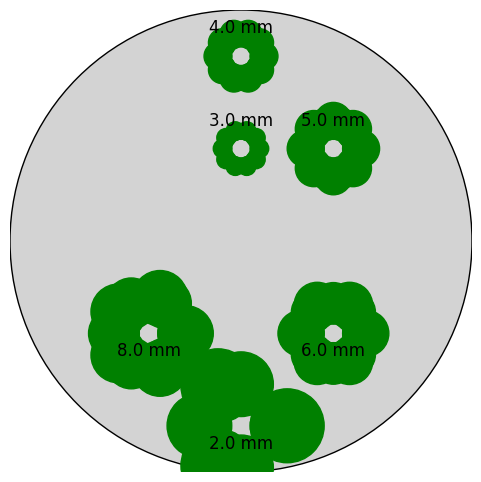

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define function to draw sectors
def draw_sector(ax, x_offset, y_offset, radii, num_circles):
    for radius, n in zip(radii, num_circles):
        for i in range(n):
            angle = 2 * np.pi * i / n
            x = x_offset + (radius + 2.0) * np.cos(angle)
            y = y_offset + (radius + 2.0) * np.sin(angle)
            circle = plt.Circle((x, y), radius, color='green')
            ax.add_patch(circle)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Draw the main circle
main_circle = plt.Circle((0, 0), 50, color='lightgrey', ec='black')
ax.add_patch(main_circle)

# Parameters for each sector
sector_params = [
    (0, 20, [1.5, 2.0], [16, 10]),  # 2 mm
    (0, 40, [2.5, 3.0], [12, 10]),  # 3 mm
    (20, 20, [3.5, 4.0], [10, 8]),  # 4 mm
    (20, -20, [4.5, 5.0], [8, 6]),  # 5 mm
    (-20, -20, [5.5, 6.0], [6, 5]), # 6 mm
    (0, -40, [7.0, 8.0], [4, 3])    # 8 mm
]

# Draw the sectors
for x_offset, y_offset, radii, num_circles in sector_params:
    draw_sector(ax, x_offset, y_offset, radii, num_circles)

# Add text labels for each sector
labels = [(0, 45, '4.0 mm'), (0, 25, '3.0 mm'), (20, 25, '5.0 mm'), (20, -25, '6.0 mm'), (-20, -25, '8.0 mm'), (0, -45, '2.0 mm')]
for (x, y, label) in labels:
    ax.text(x, y, label, fontsize=12, ha='center')

# Set the limits and aspect ratio
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_aspect('equal')

# Remove the axes
ax.axis('off')

# Display the plot
plt.show()
